(11, 3)
(3, 3)
(4, 3)
(4, 3)


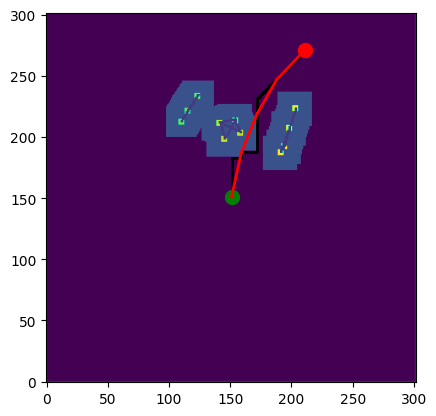

In [2]:
import numpy as np
from discretizer import Discretizer
from a_star import A_Star
import matplotlib.pyplot as plt
import ev3_dc as ev3

trajectory = []
path = []

class Main():
    def __init__(self) -> None:
        global trajectory
        global path

        world_coords=[300,300]
        landmarks = np.loadtxt("landmarks.csv", delimiter=",")
        discretizer = Discretizer(landmarks, world_coords=world_coords)
        discretizer.createMap(surrounding=12)

        a_star = A_Star(discretizer.middle_point[:2], [270,210], discretizer.world_map.transpose(1,0))
        path = a_star.find_path()
        d=a_star.d[1:world_coords[0]+1,1:world_coords[1]+1]
        trajectory = a_star.plan_trajectory(5)

        # plot shortest path
        plt.figure('Shortest path')
        plt.imshow(a_star.world_map, origin="lower")
        plt.plot(path[1],path[0], color="black", lw=2)
        plt.plot(a_star.start[1]+1,a_star.start[0]+1,'g.',markersize=20)
        plt.plot(a_star.goal[1]+1,a_star.goal[0]+1,'r.',markersize=20)


        for move in trajectory:
            plt.plot([move[0][1], move[1][1]], [move[0][0], move[1][0]], color="red", lw=2)

        plt.show()

        # self.drivePath(trajectory)

    def drivePath(self, trajectory):
        try:
            vehicle = ev3.TwoWheelVehicle (
                0.0280,
                0.1392, 
                protocol=ev3.USB
            ) 
            print("Start driving!")
            for move in trajectory:
                print(f"drive with {np.degrees(move[3])}")
                vehicle.drive_turn(np.degrees(move[3]), 0.0).start(thread=False)
                print(f"drive straight for {move[2]}cm")
                vehicle.drive_straight(move[2]).start(thread=False)

        except Exception as e:
                    print(e)
        vehicle.stop()
	
if __name__ == '__main__':
    main = Main()


In [1]:
trajectory = [[[151, 151], [195, 151], 0.44, 0.01],
            [[195, 151], [229, 162], 0.35735136770411274, 0.3029012278803845],
            [[229, 162], [249, 186], 0.31240998703626616, 0.563156822717809],
            [[249, 186], [270, 210], 0.3189043743820395, -0.024091723424921274]]

In [2]:
import ev3_dc as ev3
import numpy as np

try:
    vehicle = ev3.TwoWheelVehicle (
        0.0280,
        0.1392, 
        protocol=ev3.USB
    ) 
    print("Start driving!")
    speed = 20
    for move in trajectory:
        if np.degrees(move[3]) > 1 or np.degrees(move[3]) < -1 :
            print(f"turn with {np.degrees(move[3])} degrees")
            vehicle.drive_turn(-np.degrees(move[3]), 0.0).start(thread=False)
        if move[2]>0.01:
            print(f"drive straight for {move[2]}cm")
            vehicle.drive_straight(move[2], speed=speed).start(thread=False)

except Exception as e:
    print(e)

vehicle.stop()


Start driving!
drive straight for 0.44cm
turn with 17.354961966876413 degrees
drive straight for 0.35735136770411274cm
turn with 32.266509145727575 degrees
drive straight for 0.31240998703626616cm
turn with -1.38035407344445 degrees
drive straight for 0.3189043743820395cm


In [4]:
trajectory

[[[151, 151], [195, 151], 0.44, 0.01],
 [[195, 151], [229, 162], 0.35735136770411274, 0.3029012278803845],
 [[229, 162], [249, 186], 0.31240998703626616, 0.563156822717809],
 [[249, 186], [270, 210], 0.3189043743820395, -0.024091723424921274]]